In [ ]:
# =======================================
# 1. Import Libraries
# =======================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

np.random.seed(42)


/tmp/ipython-input-2935771945.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download("BTC-USD", start="2020-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


Dataset shape: (1827, 5)

First 5 rows:
 Price             Close         High          Low         Open       Volume
Ticker          BTC-USD      BTC-USD      BTC-USD      BTC-USD      BTC-USD
Date                                                                       
2020-01-01  7200.174316  7254.330566  7174.944336  7194.892090  18565664997
2020-01-02  6985.470215  7212.155273  6935.270020  7202.551270  20802083465
2020-01-03  7344.884277  7413.715332  6914.996094  6984.428711  28111481032
2020-01-04  7410.656738  7427.385742  7309.514160  7345.375488  18444271275
2020-01-05  7411.317383  7544.497070  7400.535645  7410.451660  19725074095

Last 5 rows:
 Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2024-12-27  94164.859375  97294.843750  93310.742188  95704.976562   
2024-12-28  95163.929688  95525.898438  94014.289062  94

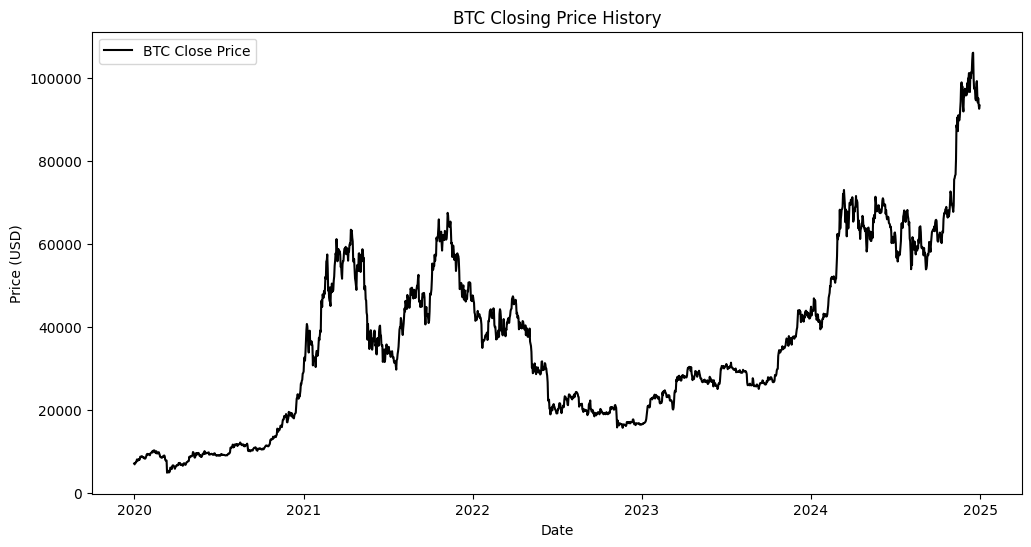

In [ ]:
# =======================================
# 2. Download Data (BTC Example)
# =======================================
btc = yf.download("BTC-USD", start="2020-01-01", end="2025-01-01")

print("Dataset shape:", btc.shape)
print("\nFirst 5 rows:\n", btc.head())
print("\nLast 5 rows:\n", btc.tail())
print(btc.describe())
print("Start date:", btc.index.min())
print("End date:", btc.index.max())
print("Total days:", len(btc))

plt.figure(figsize=(12,6))
plt.plot(btc['Close'], label="BTC Close Price", color="black")
plt.title("BTC Closing Price History")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()



In [ ]:
# =======================================
# 3. Feature Engineering
# =======================================
df = btc[['Close']].copy()

# Lags
for lag in range(1, 6):
    df[f'lag_{lag}'] = df['Close'].shift(lag)

# Moving average + returns
df['ma_7'] = df['Close'].rolling(7).mean()
df['ret_1d'] = df['Close'].pct_change()

# Target
df['target'] = df['Close'].shift(-1)

df.dropna(inplace=True)

print("Processed data shape:", df.shape)
print("\nSample rows:\n", df.head(10))



Processed data shape: (1820, 9)

Sample rows:
 Price             Close        lag_1        lag_2        lag_3        lag_4  \
Ticker          BTC-USD                                                       
Date                                                                          
2020-01-07  8163.692383  7769.219238  7411.317383  7410.656738  7344.884277   
2020-01-08  8079.862793  8163.692383  7769.219238  7411.317383  7410.656738   
2020-01-09  7879.071289  8079.862793  8163.692383  7769.219238  7411.317383   
2020-01-10  8166.554199  7879.071289  8079.862793  8163.692383  7769.219238   
2020-01-11  8037.537598  8166.554199  7879.071289  8079.862793  8163.692383   
2020-01-12  8192.494141  8037.537598  8166.554199  7879.071289  8079.862793   
2020-01-13  8144.194336  8192.494141  8037.537598  8166.554199  7879.071289   
2020-01-14  8827.764648  8144.194336  8192.494141  8037.537598  8166.554199   
2020-01-15  8807.010742  8827.764648  8144.194336  8192.494141  8037.537598   
2020-

In [ ]:
# =======================================
# 4. Train/Test Split
# =======================================
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

features = [f'lag_{i}' for i in range(1,6)] + ['ma_7','ret_1d']

X_train, y_train = train[features], train['target']
X_test, y_test = test[features], test['target']

print("Training size:", X_train.shape, "Test size:", X_test.shape)



Training size: (1456, 7) Test size: (364, 7)


In [ ]:
# =======================================
# 5. Baseline Model (Linear Regression)
# =======================================
model = make_pipeline(StandardScaler(), LinearRegression())
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

print("Model training completed successfully!")



Model training completed successfully!


In [ ]:
# =======================================
# 6. Evaluation Metrics
# =======================================
train_rmse = np.sqrt(mean_squared_error(y_train, pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, pred_test))
test_mae = mean_absolute_error(y_test, pred_test)

print("Train RMSE:", round(train_rmse, 2))
print("Test RMSE:", round(test_rmse, 2))
print("Test MAE :", round(test_mae, 2))

# Directional Accuracy (did we get up/down right?)
direction_acc = ((np.sign(pred_test[1:] - X_test['lag_1'].values[1:])
                  == np.sign(y_test.values[1:] - X_test['lag_1'].values[1:])).mean())

print("Directional Accuracy:", round(direction_acc*100, 2), "%")

# Show a sample comparison
comparison = pd.DataFrame({
    "Actual": y_test[:10].values,
    "Predicted": pred_test[:10]
}, index=y_test[:10].index)

print("\nSample Predictions vs Actual:\n")
print(comparison)


Train RMSE: 1249.38
Test RMSE: 2058.0
Test MAE : 1489.49
Directional Accuracy: 72.45 %

Sample Predictions vs Actual:

                  Actual     Predicted
Date                                  
2024-01-02  42848.175781  44841.473959
2024-01-03  44179.921875  43637.488591
2024-01-04  44162.691406  43826.357068
2024-01-05  43989.195312  44142.892086
2024-01-06  43943.097656  43632.050494
2024-01-07  46970.503906  43843.830406
2024-01-08  46139.730469  46344.709360
2024-01-09  46627.777344  46209.364796
2024-01-10  46368.585938  46481.178751
2024-01-11  42853.167969  46585.202044


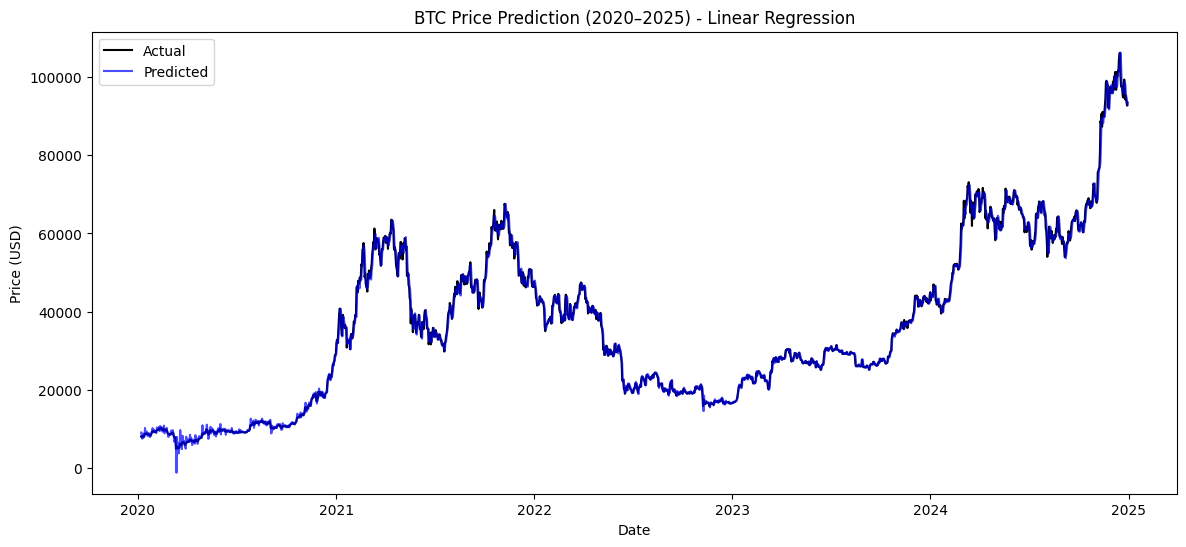

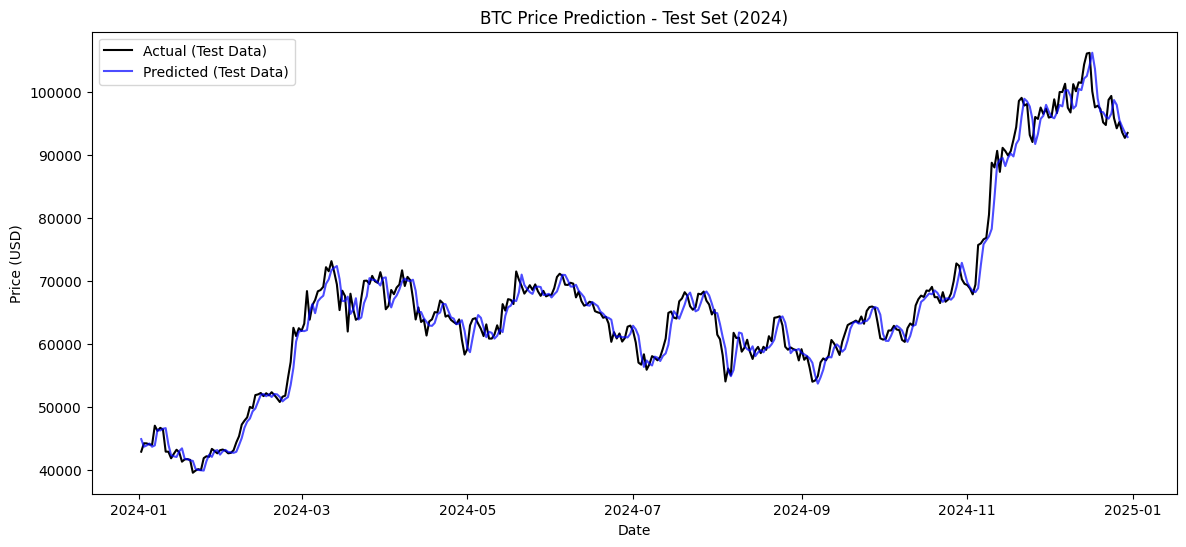

In [ ]:
# =======================================
# 7. Visualization
# =======================================
import matplotlib.pyplot as plt
import pandas as pd

# =======================================
# Combine predictions for full dataset
# =======================================
full_pred = pd.Series(index=df.index, dtype=float)
full_pred.loc[X_train.index] = pred_train
full_pred.loc[X_test.index] = pred_test

# Plot full range
plt.figure(figsize=(14,6))
plt.plot(df['target'], label="Actual", color="black")
plt.plot(full_pred, label="Predicted", color="blue", alpha=0.7)
plt.title("BTC Price Prediction (2020–2025) - Linear Regression")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# =======================================
# Zoom into Test Set (2024)
# =======================================
plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test, label="Actual (Test Data)", color="black")
plt.plot(y_test.index, pred_test, label="Predicted (Test Data)", color="blue", alpha=0.7)
plt.title("BTC Price Prediction - Test Set (2024)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

